In [ ]:
!conda install graphviz -y

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt


In [3]:
#writing a wrapper value class as a building block for neurons
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
          self.grad += 1 * out.grad
          other.grad += 1 *out.grad       
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
        self.grad += other.data * out.grad
        other.grad += self.data *out.grad
    out._backward = _backward
    return out      
      
  def __radd__(self, other):
      return self+other
      
  def __rmul__(self, other):
      return self*other
      
  def __truediv__(self, other):
      return self*other**-1 
      
  def __neg__(self):
      return self*-1
      
  def __sub__(self, other):
      return self+(-other)
      
  def __pow__(self, other):
      assert isinstance(other, (int,float))
      out = Value(self.data**other, (self, ), f'**{other}')
      def _backward():
          self.grad += other*self.data**(other-1) * out.grad
      out._backward = _backward 
      return out

  def tanh(self):
    n= self.data
    t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
    out = Value(t, (self, ), 'tanh')
    def _backward():
        self.grad += (1-t**2) * out.grad
    out._backward = _backward
    return out   
      
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
        self.grad += out.data *out.grad
    out._backward = _backward
    return out
      
  def backward(self):
    self.grad = 1
    topo = [] #using topological sort function so that Values are in correct order for backprop
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)
    for node in reversed(topo):
        node._backward()

In [4]:
#grapher
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad % .4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [5]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [6]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #weight
        self.b = Value(random.uniform(-1,1)) #bias
    def __call__(self, x):
        # w * x + ba
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP: #multi-layer perceptron
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
        
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [7]:
#EXAMPLE DATASET
n = MLP(3,[4,4,1])
xs = [
    [2,3,-1],
    [3,-1,0.5],
    [0.5,1,1],
    [1,1,-1],
]
ys = [1,-1,-1,1]

0 5.901337561285715
1 2.989918591080861
2 2.517998315559133
3 2.0434543313589515
4 1.53552638340084
5 1.0516898765650082
6 0.6915959775791766
7 0.47309021279321173
8 0.3439002500312851
9 0.26526791666259786
10 0.2133951745179848
11 0.17705265358413985
12 0.15044557726205188
13 0.13026252286311138
14 0.11450415085541141
15 0.101904548688729
16 0.09162886468286238
17 0.08310701931497108
18 0.07593792375625688
19 0.06983200419061375
20 0.06457544649645361
21 0.0600072355489716
22 0.056003991179826185
23 0.05246970072984787
24 0.04932861083514104
25 0.046520207355519996
26 0.04399560583338725
27 0.04171491367497737
28 0.03964527380859602
29 0.03775939410257813


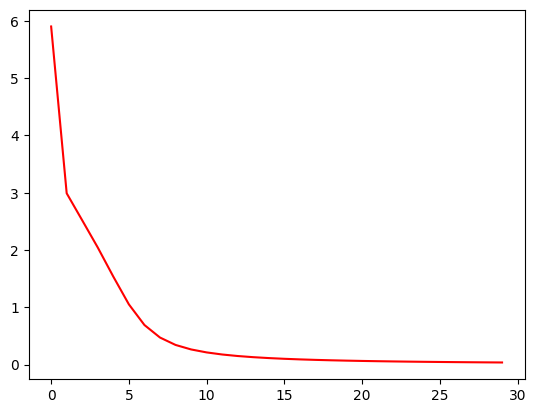

In [8]:
plot = []
for k in range(30):
#forward pass:
    ypred = [n(x) for x in xs]
    loss = sum([(yout-ygt)**2 for ygt, yout in zip(ys,ypred)])

#backward pass:
    for p in n.parameters():
        p.grad = 0 #zero the grad
    loss.backward()

#update:
    for p in n.parameters():
        p.data += -0.05*p.grad #learning rate = 0.05
    print(k,loss.data)
    plot.append(loss.data)

plt.plot(np.arange(30),plot,'r')

__INTRO TO PYTORCH__
PyTorch does the same thing as micrograd, except micrograd is only capable of single item Tensors

In [9]:
import torch

In [10]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) #forward pass
o.backward()

print('---')
print('x2', x2.grad.item()) #backward pass
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737
